In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import reuters
from collections import defaultdict, Counter
import re
from nltk import ngrams
from tqdm import tqdm

## Preprocessing

In [2]:
raw_text = reuters.sents()
raw_text = [" ".join(i) for i in raw_text]
raw_text[:5]

["ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said .",
 'They told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And lead to curbs on American imports of their products .',
 "But some exporters said that while the conflict would hurt them in the long - run , in the short - term Tokyo ' s loss might be their gain .",
 "The U . S . Has said it will impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to stick to a pact not to sell semiconductors on world markets at below cost .",
 'Unofficial Japanese estimates put the impact of the tariffs at 10 billion dlrs and spokesmen for major electronics firms said they would virtually halt expo

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [4]:
import string
text = []
for sentence in tqdm(raw_text):
    sentence = re.sub("[^a-z]", " ", sentence.lower()) # punctuation and digits
    sentence = " ".join([word for word in sentence.split() if word not in stop_words and len(word) > 2]) # stop words + stemming
    if sentence != "":
        text.append(sentence)
text[:5]

100%|██████████| 54716/54716 [00:03<00:00, 15636.45it/s]


['asian exporters fear damage japan rift mounting trade friction japan raised fears among many asia exporting nations row could inflict far reaching economic damage businessmen officials said',
 'told reuter correspondents asian capitals move japan might boost protectionist sentiment lead curbs american imports products',
 'exporters said conflict would hurt long run short term tokyo loss might gain',
 'said impose mln dlrs tariffs imports japanese electronics goods april retaliation japan alleged failure stick pact sell semiconductors world markets cost',
 'unofficial japanese estimates put impact tariffs billion dlrs spokesmen major electronics firms said would virtually halt exports products hit new taxes']

In [5]:
# create vocab
words = [j for i in text for j in i.split()]
vocab = set(words)
len(vocab)

28723

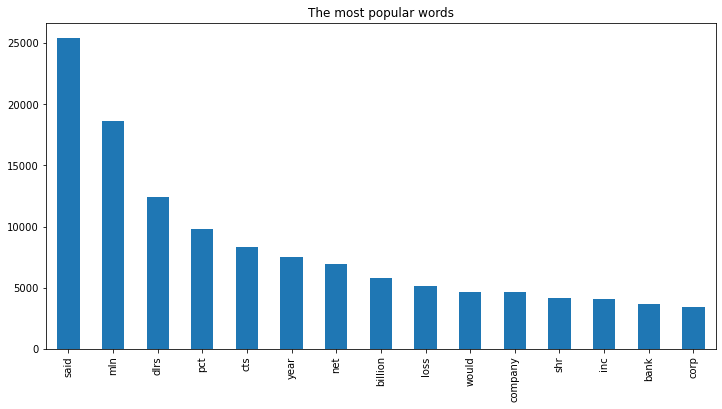

In [6]:
plt.figure(figsize=(12, 6))
pd.Series(words).value_counts().head(15).plot(kind='bar')
plt.title('The most popular words')
plt.show()

## Build Model

In [7]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(text)
len(train_text), len(test_text)

(40803, 13602)

In [8]:
# handle unknown words
words_train = words = [j for i in train_text for j in i.split()]
vocab_train = set(words_train)
unk_words = [i[0] for i in Counter(words_train).items() if i[1] == 1]
for i in tqdm(range(len(train_text))):
    sentence = train_text[i]
    sentence = [j if j not in unk_words else '<UNK>' for j in sentence.split()]
    train_text[i] = " ".join(sentence)

100%|██████████| 40803/40803 [01:56<00:00, 349.50it/s]


In [9]:
def count_n_grams(n, train_text):
    # init model
    model = defaultdict(lambda: defaultdict(lambda: 0))
    # create counts
    for sentence in train_text:
        for n_gram in ngrams(sentence.split(), n=n, pad_right=True, pad_left=True,
                             right_pad_symbol='</s>', left_pad_symbol='<s>'):
            model[(n_gram[:-1])][n_gram[-1]] += 1
    
    return model

In [10]:
model = count_n_grams(4, train_text)

# calculate probabilities
for n_gram in model.keys():
    P_n_gram = sum(model[n_gram].values())
    for word in model[n_gram]:
        model[n_gram][word] /= P_n_gram
    model[n_gram] = {k: v for k, v in sorted(model[n_gram].items(), key=lambda item: item[1], reverse=True)}

In [11]:
# generate the most popular sentence
key1 = '<s>'
key2 = '<s>'
key3 = '<s>'
sentence = ['<s>', '<s>', '<s>']
probs = []
while model[key1, key2, key3] != {}:
    key4 = next(iter(model[key1, key2, key3]))
    sentence.append(key4)
    probs.append(next(iter(model[key1, key2, key3].values())))
    if key4 == '</s>':
        break
    key1 = key2
    key2 = key3
    key3 = key4
    
print(" ".join(sentence[3:]))

said company would continue active takeover policy would wary paying current price earnings ratio times net profit </s>


In [12]:
def perplexity(probs):
    res = 1
    for i in probs:
        res *= 1/i ** (1/len(probs))
    return res

print(f'The most popular sentence perplexity: {round(perplexity(probs), 2)}')

The most popular sentence perplexity: 1.94


### Calculate perplexity

In [13]:
def get_probs(text, n, vocab, model, smoothing=None, k=None):
    assert smoothing == k or (smoothing != None and k != None)
    probs = []
    for sentence in text:
        for n_gram in ngrams(sentence.split(), n=n, pad_right=True, pad_left=True,
                             right_pad_symbol='</s>', left_pad_symbol='<s>'):
            if smoothing == None:
                n_gram = tuple(['<UNK>' if i not in vocab else i for i in n_gram])
            try:
                current_prob = model[n_gram[:-1]][n_gram[-1]]
            except:
                if smoothing == 'add-k':
                    current_prob = 1 / len(vocab)
                else:
                    continue
            if current_prob != 0:
                probs.append(current_prob)
    return probs
    

def calculate_perplexity(n, train_text, test_text, smoothing=None, k=None):
    assert smoothing == k or (smoothing != None and k != None)
    vocab_train = set([j for i in train_text for j in i.split()])
    # get the model
    model = count_n_grams(n, train_text)
    # calculate probabilities
    if smoothing == 'add-k':
        for n_gram in model.keys():
            P_n_gram = sum(model[n_gram].values()) + k*len(vocab_train)
            for word in model[n_gram]:
                model[n_gram][word] = (model[n_gram][word] + k) / P_n_gram
            model[n_gram] = {k: v for k, v in sorted(model[n_gram].items(), key=lambda item: item[1], reverse=True)}
    else:
        for n_gram in model.keys():
            P_n_gram = sum(model[n_gram].values())
            for word in model[n_gram]:
                model[n_gram][word] /= P_n_gram
            model[n_gram] = {k: v for k, v in sorted(model[n_gram].items(), key=lambda item: item[1], reverse=True)}
    # train
    probs_train = get_probs(train_text, n, vocab, model, smoothing, k)
    pp_train = perplexity(probs_train)
    # test
    probs_test = get_probs(test_text, n, vocab, model, smoothing, k)
    pp_test = perplexity(probs_test)
    
    return round(pp_train, 2), round(pp_test, 2)

In [14]:
for i in range(2, 6):
    pp_train, pp_test = calculate_perplexity(i, train_text, test_text)
    print(f'N-Grams: {i}, Perplexity train: {pp_train}, perplexity test: {pp_test}')

N-Grams: 2, Perplexity train: 61.91, perplexity test: 56.58
N-Grams: 3, Perplexity train: 3.2, perplexity test: 5.45
N-Grams: 4, Perplexity train: 1.37, perplexity test: 2.03
N-Grams: 5, Perplexity train: 1.14, perplexity test: 1.52


### Smoothing

In [15]:
# k-smoothing
def grid_search(k_grid, n, train_text, test_text):
    best_pp_test = np.inf
    best_k = k_grid[0]
    for k in k_grid:
        _, pp_test = calculate_perplexity(n, train_text, test_text, smoothing='add-k', k=k)
        print(f'Current pp_test: {pp_test}')
        if pp_test < best_pp_test:
            best_pp_test = pp_test
            best_k = k
    return best_k, best_pp_test

In [16]:
best_k, best_pp_test = grid_search([0.1, 0.3, 0.5, 0.7, 0.9, 1], 2, train_text, test_text)
print(f'Best k for n=2 is {best_k}')

Current pp_test: 1072.34
Current pp_test: 1702.35
Current pp_test: 2147.97
Current pp_test: 2509.1
Current pp_test: 2817.85
Current pp_test: 2957.77
Best k for n=2 is 0.1
